<h2 style="text-align:center;font-size:200%;;">泰坦尼克号幸存者预测 </h2> <h3  style="text-align:center;">数据清洗实战作业 </h3>

### 一、数据集简介与环境准备

##### 1. 数据集简介

- 泰坦尼克号幸存者预测是Kaggle上的经典练习题，该赛题数据要求参赛者利用891个训练样本训练分类模型，预测418个测试样本对应的船员幸存与否，为一二分类问题。

##### 2. 环境准备

运行该Jupyter时的环境:
- OS: Ubuntu 20.04 LTS
- Python: 3.9.7
- Requirements: './requirements.txt'

In [22]:
## 数据操作
import numpy as np
import pandas as pd
np.random.seed(42)

## 画图
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("bright")

## 机器学习模型
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### 二、数据集导入与字段理解

##### 1. 数据集导入

- 使用Pandas导入数据

In [23]:
## 用pandas读入数据，得到训练和测试的dataframe
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')

- 为方便数据预处理，先合并训练集与测试集，之后再分开

In [24]:
## 给test_df加一列Survived量，先全部设置为-1
test_df.insert(1, 'Survived', -1)

## 合并两个数据集
all_data = pd.concat([train_df, test_df], ignore_index=True)

##### 2. 字段理解

In [25]:
## 查看前三条数据
all_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 三、缺失值处理

##### 1. 概览数据情况

In [26]:
## 数据概况
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


可以看到，在全部数据中:
- "Fare"字段缺失了1个值
- "Embarked"字段缺失了2个值
- "Age"字段缺失了263个值
- "Cabin"字段缺失了1014个值

##### 2. 处理缺失值

- Fare
  - 连续型变量，且只有一个缺失，使用均值填充

In [27]:
## 均值填充
fare_mean = all_data['Fare'].mean()
all_data['Fare'].fillna(fare_mean, inplace=True)

- Embarked
  - 离散型变量，使用众数填充

In [28]:
## 众数填充
embarked_mode = all_data['Embarked'].mode()[0]
all_data['Embarked'].fillna(embarked_mode, inplace=True)

- Age
  - 绘制出分布，发现类似正态分布，则考虑使用均值一个标准差内的数据进行填充

<AxesSubplot:xlabel='Age', ylabel='Density'>

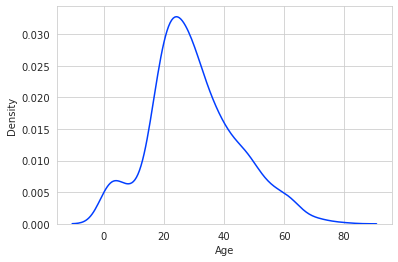

In [29]:
## 绘制出存在的Age数据的分布
sns.kdeplot(all_data['Age'])

In [30]:
## 使用未缺失年龄的均值一个标准差内的随机数填充
age_mean = all_data['Age'].mean()
all_data['Age'].fillna(np.random.normal(age_mean, 1), inplace=True)

- Cabin
  - 由于字段缺失很严重，建立一个"Has_Cabin"的新变量，"Cabin"缺失记为0，"Cabin"未缺失则记为1

In [31]:
## 将有无Cabin作为一个新特征Has_Cabin，有则填充1，无则填充0
all_data['Has_Cabin'] = 1 - all_data['Cabin'].isna()

### 四、异常值处理

In [32]:
## 查看数据统计情况
all_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Has_Cabin
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,-0.058060,2.294882,29.980936,0.498854,0.385027,33.295479,0.225363
std,378.020061,0.760044,0.837836,12.884732,1.041658,0.865560,51.738879,0.417981
min,1.000000,-1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,-1.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,30.377852,0.000000,0.000000,14.454200,0.000000
75%,982.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000,0.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


- 年龄的最大值80已结偏离均值3个标准差，比较异常，画出"Age"字段箱型图

<AxesSubplot:ylabel='Age'>

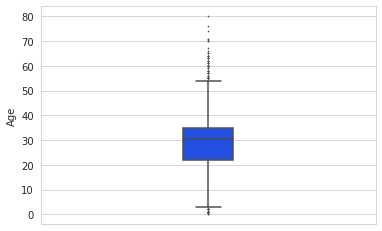

In [33]:
## 给Age字段画出箱形图
sns.boxplot(y = all_data['Age'], width=0.15, fliersize=0.8)

- 考虑到实际情况，船上有老人和小孩是很正常的，因此保留数据，不认为是异常值

### 五、数据变换

- Ticket
  - 船票号码与是否幸存关系不大，删去该无关特征

In [34]:
## 删除PassengerId
all_data.drop(columns=['Ticket'], inplace=True)

- Sex
  - 将性别离散特征化

In [35]:
## Male -> 0, Female -> 1
sex_map = pd.factorize(all_data['Sex'])
all_data['Sex'] = sex_map[0]

- Embarked
  - 将登船港口离散特征化

In [36]:
## S -> 0, C -> 1, Q -> 2
embarked_map = pd.factorize(all_data['Embarked'])
all_data['Embarked'] = embarked_map[0]

- Name
  - 主要关注前缀，增加一列"Title"条目，将常见的前缀如"Mr","Mrs"等离散特征化，其余少见的归为另一类

In [37]:
## 添加一行Title列，初始全置为0
all_data.insert(4, 'Title', 0)
## 获取含有关键词的列
mr_class = all_data['Name'].str.contains('Mr\.')
miss_class = all_data['Name'].str.contains('Miss\.')
mrs_class = all_data['Name'].str.contains('Mrs\.')
master_class = all_data['Name'].str.contains('Master\.')
## Mr. -> 1, Mrs./Miss -> 2, Master. -> 3
all_data.loc[all_data['Name'].str.contains('Mr\.'), 'Title'] = 1
all_data.loc[(all_data['Name'].str.contains('Miss\.')) | (all_data['Name'].str.contains('Mrs\.')), 'Title'] = 2
all_data.loc[all_data['Name'].str.contains('Master\.'), 'Title'] = 3

### 六、特征工程

##### 1. 相关性分析

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

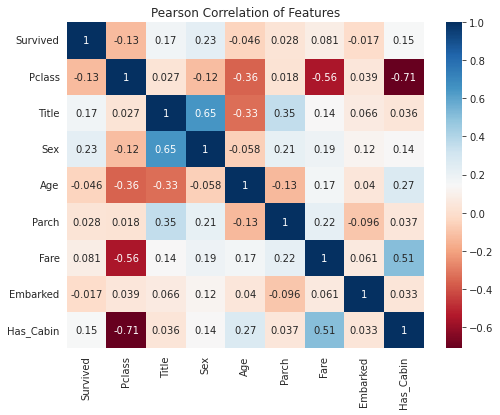

In [38]:
## 抽出一些可量化数值
drop_elements = ['PassengerId', 'Name', 'Cabin', 'SibSp']
quantifiable_data = all_data.drop(drop_elements, axis = 1)
## 绘制热力图
colormap = plt.cm.RdBu
plt.figure(figsize=(8,6))
plt.title('Pearson Correlation of Features')
sns.heatmap(quantifiable_data.astype(float).corr(), cmap=colormap, annot=True)

##### 2. 训练分类模型

- 获得训练集与测试集

In [39]:
## 分离训练集与测试集
train_df = quantifiable_data.loc[(quantifiable_data['Survived'] == 0) | (quantifiable_data['Survived'] == 1)]
test_df = quantifiable_data.loc[quantifiable_data['Survived'] == -1]
## 分离训练/测试数据与标签
X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop('Survived', axis=1)
## 打印数据形状
print("X_train:")
print(X_train.shape)
print("Y_train:")
print(Y_train.shape)
print("X_test:")
print(X_test.shape)

X_train:
(891, 8)
Y_train:
(891,)
X_test:
(418, 8)


(1) Logistic回归

In [40]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train,Y_train)*100, 2)
print(f"Train Accuracy of Logitstic Regression:{acc_log}")

Train Accuracy of Logitstic Regression:80.36


/home/chen/Code/anaconda3/envs/d2l/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(2) 支持向量回归(SVC)

In [41]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_svc = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
print(f"Train Accuracy of SVC:{acc_svc}")

Train Accuracy of SVC:68.01


(3) K邻近聚类(KNN)

In [42]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(f"Train Accuracy of KNN:{acc_knn}")

Train Accuracy of KNN:84.4


(4) 朴素贝叶斯

In [43]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_gaussian = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(f"Train Accuracy of GNB:{acc_gaussian}")

Train Accuracy of GNB:77.22


(5) 感知机

In [44]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_perceptron = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print(f"Train Accuracy of Perceptron:{acc_perceptron}")

Train Accuracy of Perceptron:68.13


(6) 决策树

In [45]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_decision_tree = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(f"Train Accuracy of Decision Tree:{acc_decision_tree}")

Train Accuracy of Decision Tree:98.65


##### 3. 结果比较

In [46]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Naive Bayes', 'Perceptron', 'Decision Tree'],
    'Score': [acc_svc, acc_knn, 
              acc_log, 
              acc_gaussian, 
              acc_perceptron,  
              acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
5,Decision Tree,98.65
1,KNN,84.40
2,Logistic Regression,80.36
3,Naive Bayes,77.22
4,Perceptron,68.13
0,Support Vector Machines,68.01


- 可以看出，比较而言，决策树的效果最好